In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Import Libraries

In [2]:
import re
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity

# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/spotify.csv').drop_duplicates()
data

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174379,0.795000,['Alessia Cara'],0.429,144720,0.211,0,45XnLMuqf3vRfskEAMUeCH,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174381,0.795000,['Alessia Cara'],0.429,144720,0.211,0,4pPFI9jsguIh3wC7Otoyy8,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174383,0.795000,['Alessia Cara'],0.429,144720,0.211,0,52YtxLVUyvtiGPxwwxayHZ,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174385,0.795000,['Alessia Cara'],0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172230 entries, 0 to 174387
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      172230 non-null  float64
 1   artists           172230 non-null  object 
 2   danceability      172230 non-null  float64
 3   duration_ms       172230 non-null  int64  
 4   energy            172230 non-null  float64
 5   explicit          172230 non-null  int64  
 6   id                172230 non-null  object 
 7   instrumentalness  172230 non-null  float64
 8   key               172230 non-null  int64  
 9   liveness          172230 non-null  float64
 10  loudness          172230 non-null  float64
 11  mode              172230 non-null  int64  
 12  name              172230 non-null  object 
 13  popularity        172230 non-null  int64  
 14  release_date      172230 non-null  object 
 15  speechiness       172230 non-null  float64
 16  tempo             17

In [9]:
data.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

In [10]:
data.duplicated().sum()

0

### 3.2.  Columns Processing

In [4]:
data['artists'] = data['artists'].apply(lambda x: re.sub(r'[\[\]]|\'+|\"+', '', x))

In [5]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'valence', 'year']
Categorical Columns : ['artists', 'id', 'name', 'release_date']


### 3.3. EDA

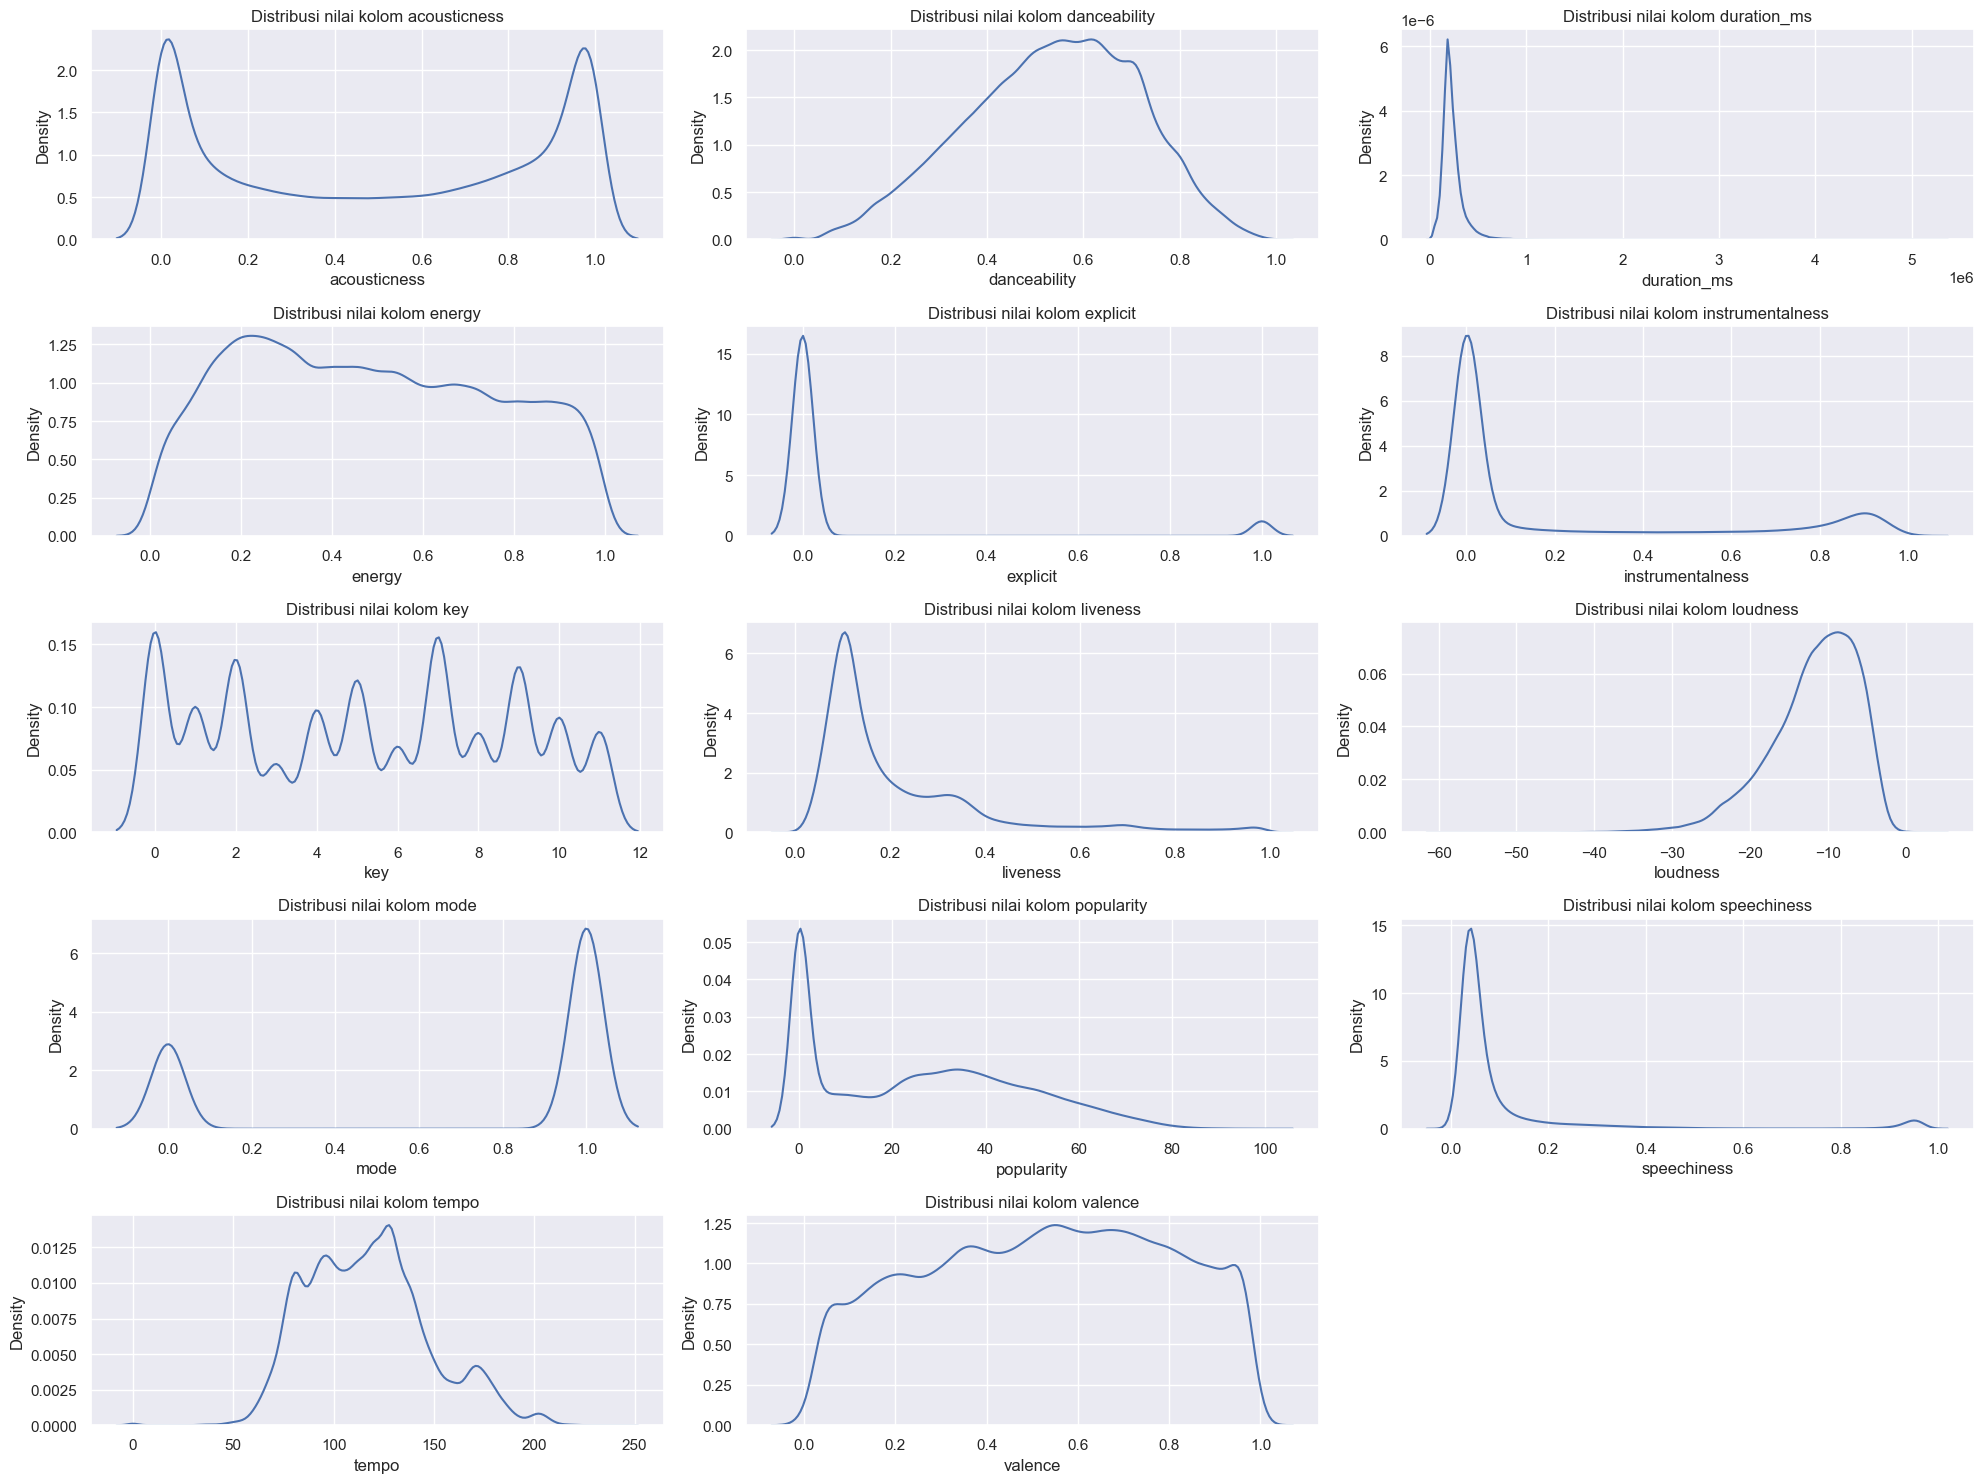

In [16]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

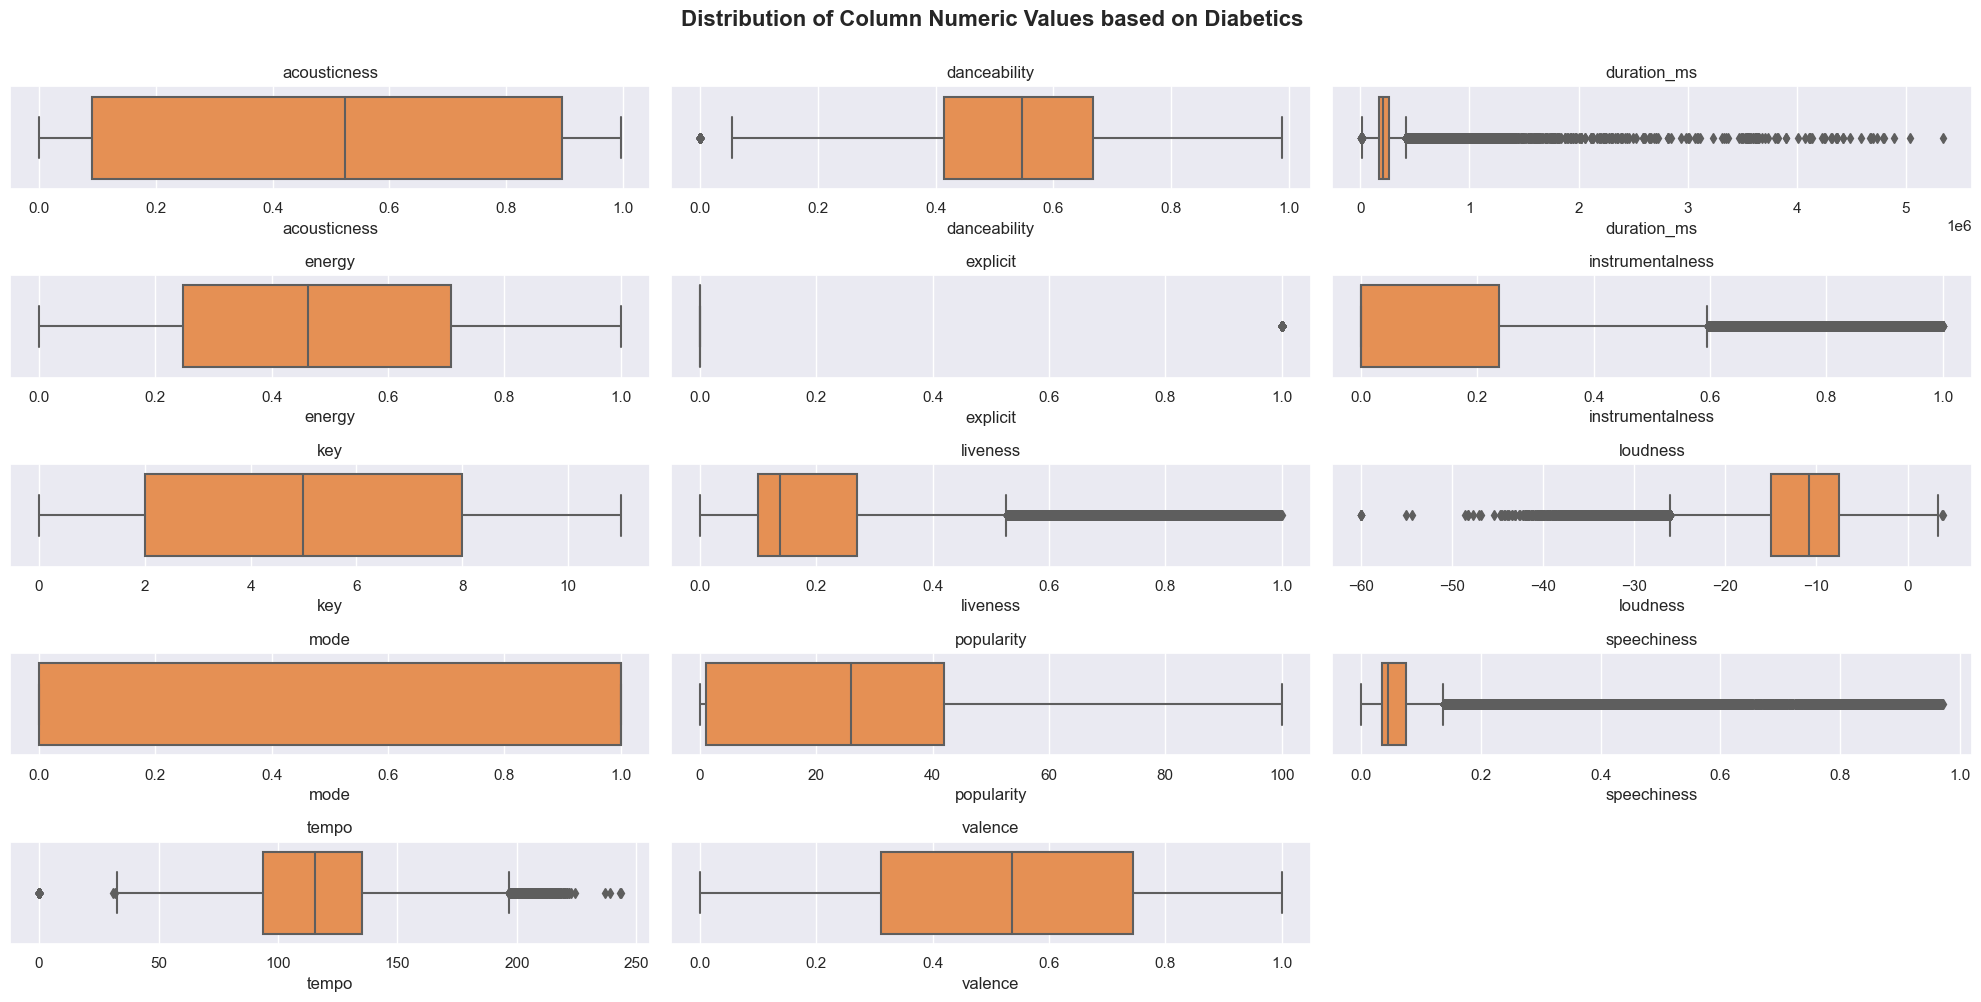

In [17]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

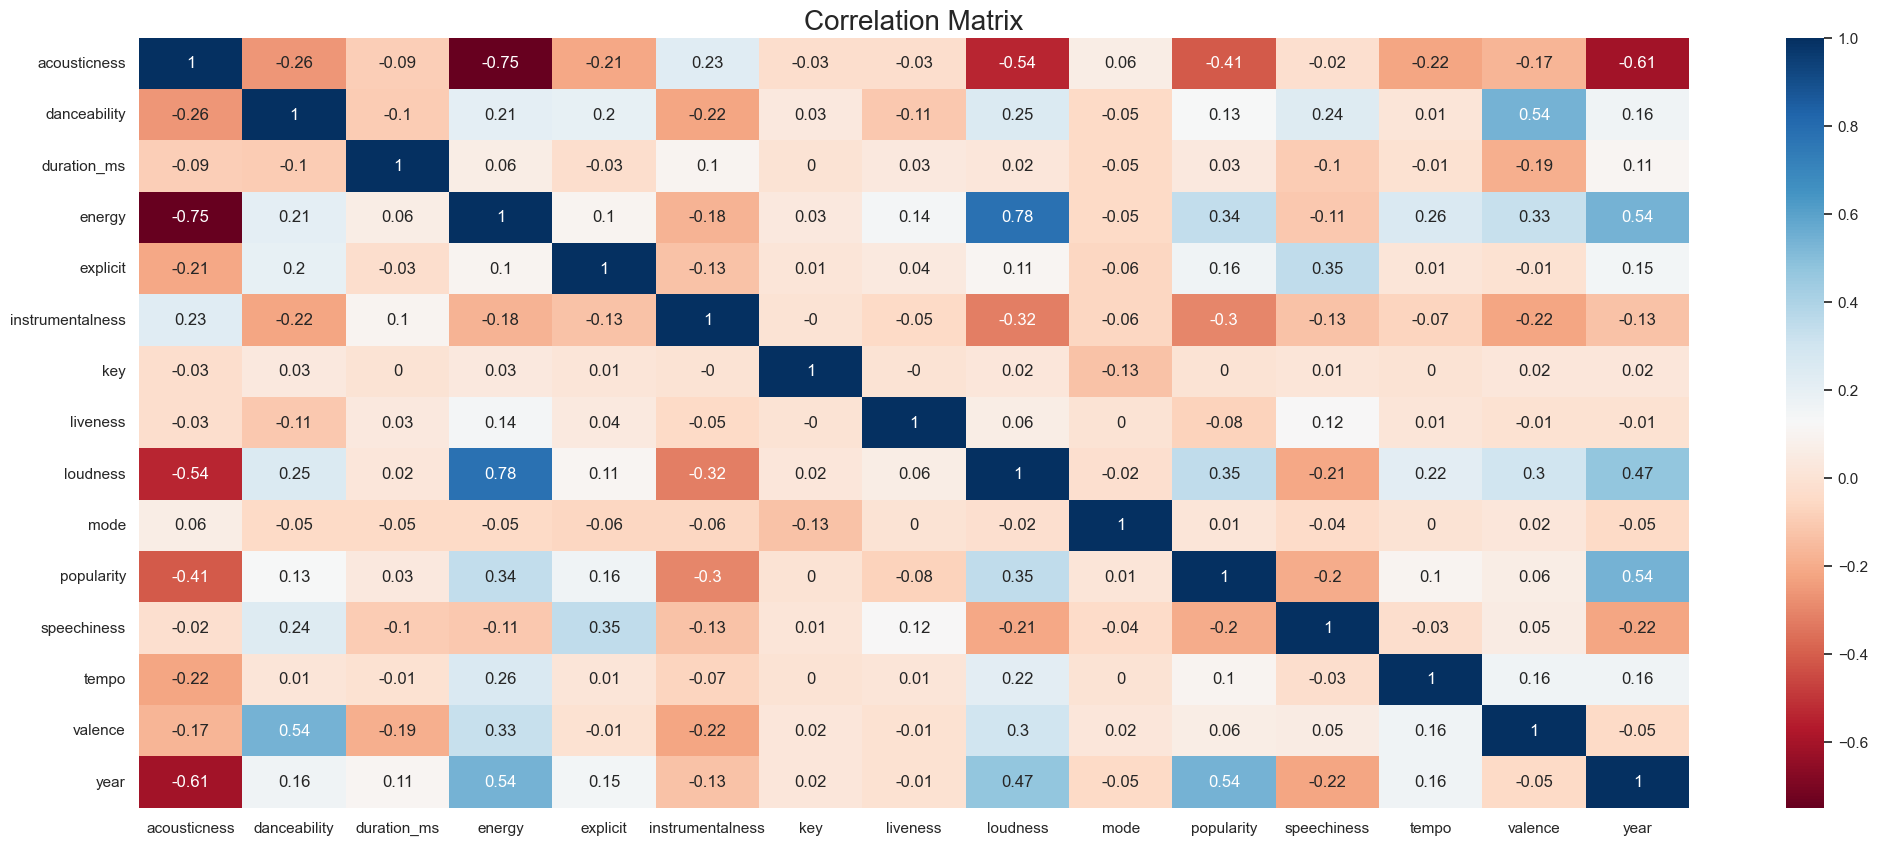

In [7]:
corr_data = data[numerical_columns].corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Transformation

In [6]:
from sklearn.preprocessing import MinMaxScaler
datatypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
normarization = data.select_dtypes(include=datatypes)
for col in normarization.columns:
    MinMaxScaler(col)

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
features = kmeans.fit_predict(normarization)
data['features'] = features
MinMaxScaler(data['features'])

c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MinMaxScaler(feature_range=0         3
1         3
2         3
3         9
4         3
         ..
174379    3
174381    3
174383    3
174385    3
174387    0
Name: features, Length: 172230, dtype: int32)

# 5. Recodemmendation System

In [22]:
class Spotify_Recommendation():
    def __init__(self, dataset):
        self.dataset = dataset
    def recommend(self, songs, amount=1):
        distance = []
        try : 
            song = self.dataset[(self.dataset.name.str.lower() == songs.lower())].head(1).values[0]
            rec = self.dataset[self.dataset.name.str.lower() != songs.lower()]
        
            for songs in tqdm(rec.values):
                d = 0
                for col in np.arange(len(rec.columns)):
                    if not col in [1, 6, 12, 14, 18]:
                        d = d + np.absolute(float(song[col]) - float(songs[col]))
                distance.append(d)

            rec['distance'] = distance
            rec = rec.sort_values('distance')
            columns = ['artists', 'name']
            return rec[columns][:amount]
        except:
            print("Song not found. Please enter another title!!!")

recommendations = Spotify_Recommendation(data)
recommendations.recommend("Those Eyes", 10)

Song not found. Please enter another title!!!
